In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = Path.cwd().parent.joinpath('data', 'processed', 'three_factor_model.txt')

In [3]:
df = pd.read_csv(DATA_PATH, delimiter = "\t")

In [4]:
df.head()

,datadate,tic,conm,prccq,chng,chng_cs,excess,Price_tb,book_value,bv_per_share,ptb,cshoc,prccd,prcod,mkvaltq
0,2000-03-31,ABF,AIRBORNE INC,24.0000,NaN,-0.014137,-0.072737,5.860,894267000.0,18.339048,1.308683,48763000.0,24.0000,NaN,1.170312e+09
1,2000-06-30,ABF,AIRBORNE INC,18.9375,-0.210938,0.008527,-0.050073,5.860,884944000.0,18.054923,1.048883,49014000.0,18.9375,NaN,9.282026e+08
2,2001-12-31,ABF,AIRBORNE INC,14.8300,0.552880,0.004970,-0.012390,1.736,834216000.0,17.341926,0.855153,48104000.0,14.8300,NaN,7.133823e+08
3,2002-09-30,ABF,AIRBORNE INC,11.3400,-0.409375,-0.074990,-0.090500,1.551,829688000.0,17.143377,0.661480,48397000.0,11.3400,NaN,5.488220e+08
4,2002-12-31,ABF,AIRBORNE INC,14.8300,0.307760,0.002302,-0.009888,1.219,839163000.0,17.329843,0.855749,48423000.0,14.8300,NaN,7.181131e+08


In [5]:
df["Price_tb"] = df["Price_tb"]/100

In [6]:
df.head()

,datadate,tic,conm,prccq,chng,chng_cs,excess,Price_tb,book_value,bv_per_share,ptb,cshoc,prccd,prcod,mkvaltq
0,2000-03-31,ABF,AIRBORNE INC,24.0000,NaN,-0.014137,-0.072737,0.05860,894267000.0,18.339048,1.308683,48763000.0,24.0000,NaN,1.170312e+09
1,2000-06-30,ABF,AIRBORNE INC,18.9375,-0.210938,0.008527,-0.050073,0.05860,884944000.0,18.054923,1.048883,49014000.0,18.9375,NaN,9.282026e+08
2,2001-12-31,ABF,AIRBORNE INC,14.8300,0.552880,0.004970,-0.012390,0.01736,834216000.0,17.341926,0.855153,48104000.0,14.8300,NaN,7.133823e+08
3,2002-09-30,ABF,AIRBORNE INC,11.3400,-0.409375,-0.074990,-0.090500,0.01551,829688000.0,17.143377,0.661480,48397000.0,11.3400,NaN,5.488220e+08
4,2002-12-31,ABF,AIRBORNE INC,14.8300,0.307760,0.002302,-0.009888,0.01219,839163000.0,17.329843,0.855749,48423000.0,14.8300,NaN,7.181131e+08


In [7]:
#excess is market excess
df.rename(columns = {"excess":"mkt_excess"}, inplace = True)

In [8]:
df.head()

,datadate,tic,conm,prccq,chng,chng_cs,mkt_excess,Price_tb,book_value,bv_per_share,ptb,cshoc,prccd,prcod,mkvaltq
0,2000-03-31,ABF,AIRBORNE INC,24.0000,NaN,-0.014137,-0.072737,0.05860,894267000.0,18.339048,1.308683,48763000.0,24.0000,NaN,1.170312e+09
1,2000-06-30,ABF,AIRBORNE INC,18.9375,-0.210938,0.008527,-0.050073,0.05860,884944000.0,18.054923,1.048883,49014000.0,18.9375,NaN,9.282026e+08
2,2001-12-31,ABF,AIRBORNE INC,14.8300,0.552880,0.004970,-0.012390,0.01736,834216000.0,17.341926,0.855153,48104000.0,14.8300,NaN,7.133823e+08
3,2002-09-30,ABF,AIRBORNE INC,11.3400,-0.409375,-0.074990,-0.090500,0.01551,829688000.0,17.143377,0.661480,48397000.0,11.3400,NaN,5.488220e+08
4,2002-12-31,ABF,AIRBORNE INC,14.8300,0.307760,0.002302,-0.009888,0.01219,839163000.0,17.329843,0.855749,48423000.0,14.8300,NaN,7.181131e+08


In [9]:
#need to make column of chng - tbill --> stock excess. probs can be done in temp files for OLS

#need to create a separate object to tabulate small versus big stocks and each time period,
#since stocks can grow and become big
#
# first step: get mkt value and returns of all stocks available at each quarter q
# second step: get percentiles at each time in terms of q
# third step: take returns of bottom 10% less top 10% (regular average) to get factor at each time step q

# need similar process for HML, tbd

In [10]:
##making SMB
dat = {'datadate':[],'SMB value':[]}
SMB = pd.DataFrame(data = dat)
j = 0
for i in np.unique(df["datadate"]):
    temp = df[df.datadate == i][["chng","mkvaltq"]]

    ten = np.nanpercentile(temp["mkvaltq"],10)
    ninety = np.nanpercentile(temp["mkvaltq"],90)
    small = temp[temp["mkvaltq"]< ten]
    big = temp[temp["mkvaltq"]> ninety]
    small_rets = np.nanmean(small["chng"])
    big_rets = np.nanmean(big["chng"])
    factor =  small_rets - big_rets
    SMB.loc[j] = [i,factor]
    j+=1

In [11]:
SMB.head()
#first row is 0 because all stocks on q1 have a nan change percent lol

,datadate,SMB value
0,2000-03-31,0.000000
1,2000-06-30,-0.193951
2,2001-12-31,0.161618
3,2002-09-30,0.028483
4,2002-12-31,0.138784


In [12]:
##making HML
dat = {'datadate':[],'HML value':[]}
HML = pd.DataFrame(data = dat)
j = 0
for i in np.unique(df["datadate"]):
    temp = df[df.datadate == i][["tic","chng","ptb"]]

    ten = np.nanpercentile(temp["ptb"],10)
    ninety = np.nanpercentile(temp["ptb"],90)
    value = temp[temp["ptb"]< ten]
    growth = temp[temp["ptb"]> ninety]
    val_rets = np.nanmean(value["chng"])
    growth_rets = np.nanmean(growth["chng"])
    factor =  val_rets - growth_rets
    HML.loc[j] = [i,factor]
    j+=1

In [13]:
HML.head()
##same thing with HML, first row isnt technically usable

,datadate,HML value
0,2000-03-31,0.000000
1,2000-06-30,0.032200
2,2001-12-31,0.014985
3,2002-09-30,-0.099567
4,2002-12-31,-0.100850


In [14]:
df = df.merge(SMB, how = "left", on = "datadate")

In [15]:
df = df.merge(HML, how = "left", on = "datadate")

In [16]:
df.head()

,datadate,tic,conm,prccq,chng,chng_cs,mkt_excess,Price_tb,book_value,bv_per_share,ptb,cshoc,prccd,prcod,mkvaltq,SMB value,HML value
0,2000-03-31,ABF,AIRBORNE INC,24.0000,NaN,-0.014137,-0.072737,0.05860,894267000.0,18.339048,1.308683,48763000.0,24.0000,NaN,1.170312e+09,0.000000,0.000000
1,2000-06-30,ABF,AIRBORNE INC,18.9375,-0.210938,0.008527,-0.050073,0.05860,884944000.0,18.054923,1.048883,49014000.0,18.9375,NaN,9.282026e+08,-0.193951,0.032200
2,2001-12-31,ABF,AIRBORNE INC,14.8300,0.552880,0.004970,-0.012390,0.01736,834216000.0,17.341926,0.855153,48104000.0,14.8300,NaN,7.133823e+08,0.161618,0.014985
3,2002-09-30,ABF,AIRBORNE INC,11.3400,-0.409375,-0.074990,-0.090500,0.01551,829688000.0,17.143377,0.661480,48397000.0,11.3400,NaN,5.488220e+08,0.028483,-0.099567
4,2002-12-31,ABF,AIRBORNE INC,14.8300,0.307760,0.002302,-0.009888,0.01219,839163000.0,17.329843,0.855749,48423000.0,14.8300,NaN,7.181131e+08,0.138784,-0.100850


In [17]:
factors = []
for tic in np.unique(df["tic"]):
    try:
        temp_df = df[df["tic"] == tic]
        temp_df = temp_df.reset_index(drop = True)
        temp_df = temp_df.dropna()
        Y = temp_df["chng"]-(temp_df["Price_tb"])
        X = temp_df[["mkt_excess","SMB value","HML value"]]
        model = OLS(Y,sm.tools.add_constant(X)).fit()
        factors.append((tic,model.params,model.pvalues,model.rsquared))
    except:
        continue

In [18]:
##plot expected value versus actual returns of a couple stocks, some with at least one (hoepfully more)
#statisitically signifcaint betas and those with none
sig = []
insig = []
for i in factors:
    if all(ele < 0.10 for ele in i[2]):
        sig.append(i)

    if all(ele > 0.6 for ele in i[2]):
        insig.append(i)

In [19]:
X = df[["datadate","tic","chng","mkt_excess","SMB value","HML value","Price_tb"]]

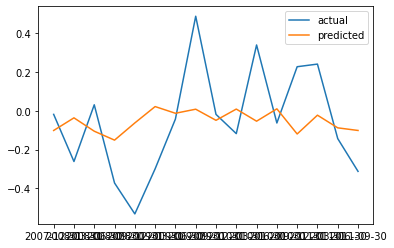

FACE MSE: 0.07255884828239291


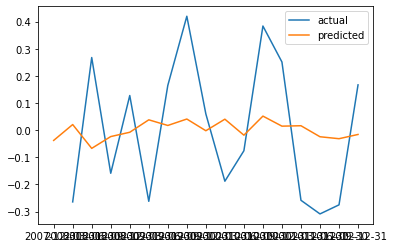

HOGS MSE: 0.05993112848145078


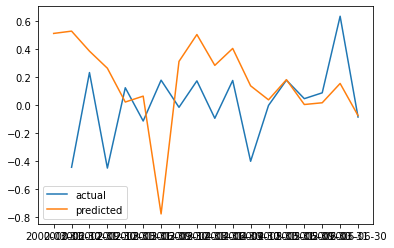

OATS MSE: 0.19996576583251469


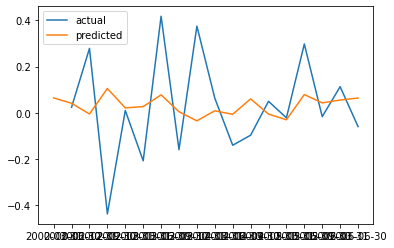

OO MSE: 0.0505869568960719


In [20]:
for i in insig:
    tic = i[0]
    temp = X[X["tic"]==tic]
    expct_exc_rets = []
    alpha = i[1][0]
    beta_ex = i[1][1]
    beta_smb = i[1][2]
    beta_hml = i[1][3]

    for j in range(len(temp)):
        ret = beta_ex*temp.iloc[j]["mkt_excess"]+beta_smb*temp.iloc[j]["SMB value"]+\
        beta_hml*temp.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
    dates = temp["datadate"].reset_index()
    plt.plot(temp["datadate"],temp["chng"]-temp['Price_tb'])
    plt.plot(temp["datadate"],expct_exc_rets)
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp["tic"].iloc[0],'MSE: '+str(mse(temp['chng'][1:]-temp['Price_tb'][1:],expct_exc_rets[1:])))


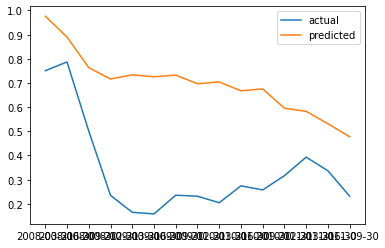

FACE MSE: 0.07255884828239291


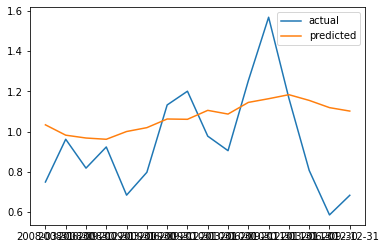

HOGS MSE: 0.05993112848145078


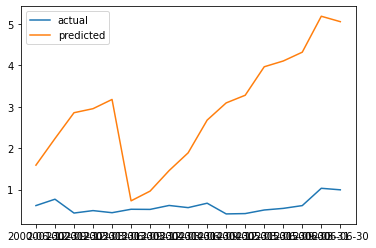

OATS MSE: 0.19996576583251469


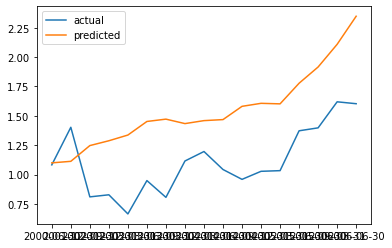

OO MSE: 0.0505869568960719


In [21]:
for i in insig:
    tic = i[0]
    temp = X[X["tic"]==tic]
    expct_exc_rets = []
    alpha = i[1][0]
    beta_ex = i[1][1]
    beta_smb = i[1][2]
    beta_hml = i[1][3]

    for j in range(len(temp)):
        ret = beta_ex*temp.iloc[j]["mkt_excess"]+beta_smb*temp.iloc[j]["SMB value"]+\
        beta_hml*temp.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
    dates = temp["datadate"].reset_index()
    gross_expct = 1+np.array(expct_exc_rets[1:])+temp['Price_tb'][1:]
    gross_actual = temp["chng"][1:]+1


    plt.plot(temp["datadate"][1:],gross_actual.cumprod())
    plt.plot(temp["datadate"][1:],gross_expct.cumprod())
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp["tic"].iloc[0],'MSE: '+str(mse(temp['chng'][1:]-temp['Price_tb'][1:],expct_exc_rets[1:])))


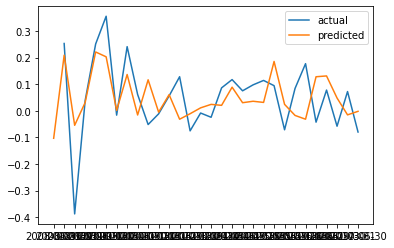

DPS MSE: 0.012454098928501972


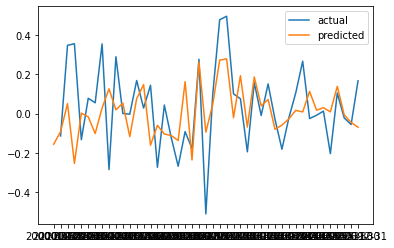

JAH MSE: 0.0381649447448703


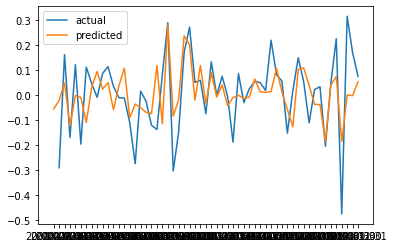

LEG MSE: 0.015774220187532304


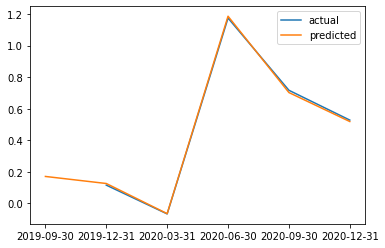

PTON MSE: 0.00010653643220904661


In [22]:
for i in sig:
    tic = i[0]
    temp = X[X["tic"]==tic]
    expct_exc_rets = []
    alpha = i[1][0]
    beta_ex = i[1][1]
    beta_smb = i[1][2]
    beta_hml = i[1][3]

    for j in range(len(temp)):
        ret = beta_ex*temp.iloc[j]["mkt_excess"]+beta_smb*temp.iloc[j]["SMB value"]+\
        beta_hml*temp.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
    dates = temp["datadate"].reset_index()
    plt.plot(temp["datadate"],temp["chng"]-temp['Price_tb'])
    plt.plot(temp["datadate"],expct_exc_rets)
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp["tic"].iloc[0],'MSE: '+str(mse(temp['chng'][1:]-temp['Price_tb'][1:],expct_exc_rets[1:])))

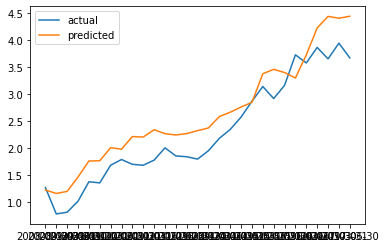

DPS


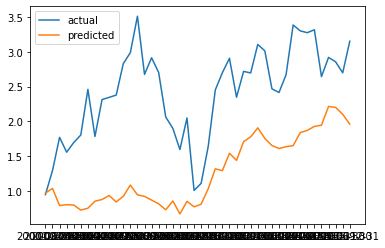

JAH


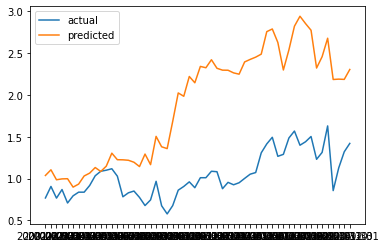

LEG


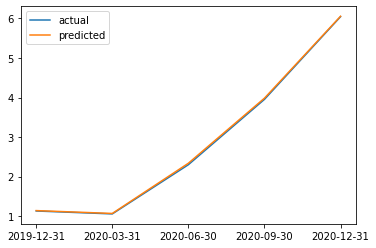

PTON


In [23]:
for i in sig:
    tic = i[0]
    temp = X[X["tic"]==tic]
    expct_exc_rets = []
    alpha = i[1][0]
    beta_ex = i[1][1]
    beta_smb = i[1][2]
    beta_hml = i[1][3]

    for j in range(len(temp)):
        ret = beta_ex*temp.iloc[j]["mkt_excess"]+beta_smb*temp.iloc[j]["SMB value"]+\
        beta_hml*temp.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
    dates = temp["datadate"].reset_index()
    gross_expct = 1+np.array(expct_exc_rets[1:])+temp['Price_tb'][1:]
    gross_actual = temp["chng"][1:]+1


    plt.plot(temp["datadate"][1:],gross_actual.cumprod())
    plt.plot(temp["datadate"][1:],gross_expct.cumprod())
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp["tic"].iloc[0])
